## Exercise Set 2 for OSM 

### Dynamic Programming with John Stachurski

Exercises for the [OSM](https://bfi.uchicago.edu/osm) bootcamp dynamic programming section.

We will use the following libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

### Exercise 1

Consider the setting of the [stochastic optimal growth model](https://lectures.quantecon.org/py/optgrowth.html), with the same notation and same assumptions on the primitives $u$, $f$, $\beta$ and $\phi$. 

Let $\mathscr C$ be all continuous bounded functions on $\mathbb R_+$.

Let $\sigma \in \Sigma$ be any feasible policy and let $U$ be the operator from $\mathscr C$ to itself defined by

$$ Uw(y) = u(\sigma(y)) + \beta \int w(f(y - \sigma(y))z) \phi(dz) \qquad (y \in \mathbb R_+)$$

Prove that $U$ is a contraction mapping with respect to the supremum distance.  Argue that the unique fixed point of $U$ in $\mathscr C$ is $v_\sigma$.

("Argue" means provide a sketch of a proof that contains the key ideas, plus some intuition.  Or give a complete, formal proof, if you can.)

#### Answer:
I have typed the proof in the pdf document bcause it would not conserve format and size of the math environment when uploading the notebook on gitHub for some reason.

### Exercise 2

Notation and concepts continue from exercise 2.

Use the fact you proved in exercise 2, combined with piecewise linear interpolation method we used for the Bellman operator, to compute and plot good approximations of the value $v_\sigma$ of the policies

* $\sigma_1(y) = 0.95 y$
* $\sigma_2(y) = H(y) y$ where $H$ is the cdf of the lognormal $LN(0, 0.5)$ distribution.

For the latter use `scipy.stats.lognorm.cdf(y, 0.5)`

For the primitives, use the default specification in the `LogLinearOG` class from the [stochastic optimal growth model lecture](https://lectures.quantecon.org/py/optgrowth.html).

Plot your results, choosing grid and plotting dimensions to best illustrate the two functions.  Based on the plot alone, argue that neither of these policies is an optimal policy.

In [7]:
from scipy.optimize import fminbound
from scipy.stats import lognorm

def U_operator(w, grid, beta, u, f, shocks, Tw=None, compute_policy=0, use_sigma=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    beta : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        sigma = np.empty_like(w)
    
    if use_sigma == 1:
        def sig(y):
            return  0.95*y
    elif use_sigma == 2:
        def sig(y):
            return lognorm.cdf(y, 0.5) * y
    else:
        def sig(y):
            return y

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(y):
            return - u(sig(y)) - beta * np.mean(w_func(f(y - sig(y)) * shocks))
        #c_star = fminbound(objective, 1e-10, y)
        c_star = y
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

In [8]:
class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)

lg = LogLinearOG()
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star = lg.v_star

In [9]:
grid_max = 4         
grid_size = 200      
shock_size = 250     

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

w = U_operator(v_star(grid),
                     grid,
                     beta,
                     np.log,
                     lambda k: k**alpha,
                     shocks,
                     use_sigma=1)

q = U_operator(v_star(grid),
                     grid,
                     beta,
                     np.log,
                     lambda k: k**alpha,
                     shocks,
                     use_sigma=2)
# fig, ax = plt.subplots(figsize=(9, 5))
# ax.set_ylim(-45, -21)
# ax.plot(grid, w, lw=2, alpha=0.6, label=r'$v_{\sigma_1}$')
# ax.plot(grid, q, lw=2, alpha=0.6, label=r'$v_{\sigma_2}$')
# ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='$v^*$')
# ax.set_xlabel(r'$y$')
# ax.legend(loc='lower right')
# plt.show()

In [14]:
from quantecon import compute_fixed_point
Tw = np.empty(len(grid))
initial_w = 5 * np.log(grid)

T1 = lambda w: U_operator(w,
                               grid,
                               beta,
                               np.log,
                               lambda k: k**alpha,
                               shocks,
                               compute_policy=False,
                                use_sigma=1)

v_star_approx1 = compute_fixed_point(T1, initial_w,
                                    error_tol=1e-5,  # error_tol
                                    max_iter=500,   # max_iter
                                    verbose=2,  # verbose
                                    print_skip=10,     # print_skip
                                    method='iteration')

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
10           1.292e+00      6.008e-02         
20           7.846e-01      1.041e-01         
30           5.118e-01      1.482e-01         
40           3.390e-01      1.923e-01         
50           2.252e-01      2.403e-01         
60           1.497e-01      2.844e-01         
70           9.951e-02      3.284e-01         
80           6.616e-02      3.725e-01         
90           4.398e-02      4.126e-01         
100          2.924e-02      4.646e-01         
110          1.944e-02      5.087e-01         
120          1.293e-02      5.527e-01         
130          8.593e-03      5.928e-01         
140          5.713e-03      6.368e-01         
150          3.798e-03      6.850e-01         
160          2.525e-03      7.370e-01         
170          1.679e-03      8.211e-01         
180          1.116e-03      8.932e-01         
190          7.420e-04      9.613e-01         
200          4.

In [15]:
Tw = np.empty(len(grid))
initial_w = 5 * np.log(grid)

T2 = lambda w: U_operator(w,
                               grid,
                               beta,
                               np.log,
                               lambda k: k**alpha,
                               shocks,
                               compute_policy=False,
                                use_sigma=2)

v_star_approx2 = compute_fixed_point(T2, initial_w,
                                    error_tol=1e-5,  # error_tol
                                    max_iter=500,   # max_iter
                                    verbose=2,  # verbose
                                    print_skip=10,     # print_skip
                                    method='iteration')

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
10           1.411e+00      4.086e-01         
20           6.570e-01      8.171e-01         
30           4.366e-01      1.394e+00         
40           2.903e-01      1.830e+00         
50           1.930e-01      2.295e+00         
60           1.283e-01      2.732e+00         
70           8.530e-02      3.116e+00         
80           5.671e-02      3.505e+00         
90           3.770e-02      3.941e+00         
100          2.507e-02      4.474e+00         
110          1.666e-02      4.923e+00         
120          1.108e-02      5.307e+00         
130          7.366e-03      5.692e+00         
140          4.897e-03      6.100e+00         
150          3.256e-03      6.505e+00         
160          2.165e-03      6.949e+00         
170          1.439e-03      7.434e+00         
180          9.567e-04      7.971e+00         
190          6.361e-04      8.475e+00         
200          4.

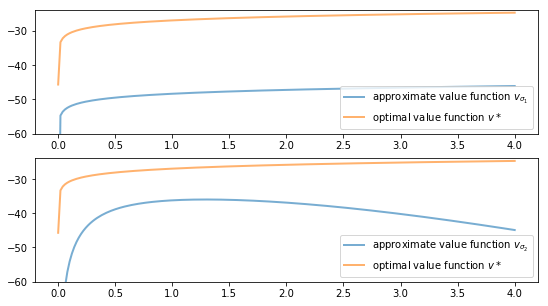

In [27]:
fig, axes = plt.subplots(2,1, figsize=(9, 5))
axes[0].set_ylim(-60, -24)
axes[0].plot(grid, v_star_approx1, lw=2, alpha=0.6, label='approximate value function $v_{\sigma_1}$')
axes[0].plot(grid, v_star(grid), lw=2, alpha=0.6, label='optimal value function $v*$ ')
axes[0].legend(loc='lower right')

axes[1].set_ylim(-60, -24)
axes[1].plot(grid, v_star_approx2, lw=2, alpha=0.6, label='approximate value function $v_{\sigma_2}$')
axes[1].plot(grid, v_star(grid), lw=2, alpha=0.6, label='optimal value function $v*$ ')
axes[1].legend(loc='lower right')
plt.show()

The optimal value function $v*$ being above the approximations for $v_{\sigma_1}$ and  $v_{\sigma_2}$ indicates that the functional forms $\sigma_1$ and $\sigma_2$ of the policy function that do not coincide with the optimal policy function, unsurprrisingly, lead to a loss in the value function compared to the optimal case $v*$. In the case of $v_{\sigma_1}$ the relative loss seems to be quite constant whereas the relative loss of $v_{\sigma_2}$ compared to $v*$ reaches is increasing for $y>2$ . However, the relative loss for $v_{\sigma_2}$ is still smaller than the loss of $v_{\sigma_1}$ for most of the plotted domain.